# Zillow Regression Project
***

__Project Goals__

* Predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.
* Determine the state and county location of each property.
* Calculate and chart the tax rate distributions for each county.

***

__Overall Findings__

* All properties are located in California.
* All properties exist in either Los Angelas, Orange, or Ventura county.
* The individual county tax rates have been calculated and their distributions plotted at the end of the Wrangle section of this notebook.
* My best model was a LassoLars model with an alpha of 31. It outperformed all others, including the baseline, and had a validate RMSE of 232,872.79

***

__My Process__

* Write a README.md file that details my process, my findings, and instructions on how to recreate my project.
* Acquire the zillow data from the Codeup Database
* Clean and prepare the zillow data:
    - Select only the useful columns
    - Remove or impute null values
    - Rename columns as necessary
    - Change data types as necessary
    - Calculate county_tax_rate
    - Create county and state columns
    - Remove entries that don't make sense or are illegal
    - Remove outliers
* Plot individual variable distributions
* Plot county_tax_rate distributions ( A Project Goal )
* Determine at least two initial hypotheses, run the statistical tests needed, evaluate the outcome, and record results.
* Split the data sets into X and y groups and scale the X groups before use in the model.
* Set baseline using tax_value mean or median.
* Create and evaluate models on train and validate sets
* Choose best model and evaluate it on test data set
* Document conclusions, takeaways, and next steps in the Final Report Notebook.
***

### Necessary Imports
***

In [1]:
import numpy as np
import pandas as pd

#For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#For stats
import scipy.stats as stats

#For modeling
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error

#Custom modules
import env
import wrangle
import explore
import model

### Acquire Data
***

__Data Dictionary__

| Target | Datatype | Definition |
|:-------|:---------|:------------|
| tax_value | int | The assessed value of the property |

| Feature | Datatype | Definition |
|:--------|:---------|:------------|
| bedroom_count | int | The number of bedrooms in the property |
| bathroom_count | float | The number of bathrooms in the property (Includes values for half baths and other combinations) |
| home_area | int | The area of the property in square feet |
| county | str | The name of the county the property resides in |
| tax_amount | float | The amount of tax paid (Used to calculate county_tax_rate) |
| state | str | The name of the state the property resides in |
| county_tax_rate | float | The tax rate applied to the property (Calculated using tax_amount and tax_value) |

***

__Retrieve the Zillow Data From the Codeup Database__

In [2]:
zillow = wrangle.wrangle_zillow()

***
__Get a Brief Overview of the Data__

In [3]:
zillow.head()

,bedroom_count,bathroom_count,home_area,county,tax_value,tax_amount,state,county_tax_rate
0,3,2.0,1316,Los Angelas,205123,2627.48,California,0.012809
1,3,2.0,1458,Los Angelas,136104,2319.90,California,0.017045
2,2,1.0,1421,Los Angelas,35606,543.69,California,0.015270
3,4,3.0,2541,Orange,880456,9819.72,California,0.011153
4,3,2.0,1491,Los Angelas,107110,1399.27,California,0.013064


In [4]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23004 entries, 0 to 28123
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedroom_count    23004 non-null  int64  
 1   bathroom_count   23004 non-null  float64
 2   home_area        23004 non-null  int64  
 3   county           23004 non-null  object 
 4   tax_value        23004 non-null  int64  
 5   tax_amount       23004 non-null  float64
 6   state            23004 non-null  object 
 7   county_tax_rate  23004 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.6+ MB


In [5]:
zillow.describe()

,bedroom_count,bathroom_count,home_area,tax_value,tax_amount,county_tax_rate
count,23004.000000,23004.000000,23004.000000,2.300400e+04,23004.000000,23004.000000
mean,3.176143,2.069227,1691.850504,3.960398e+05,4824.871216,0.012801
std,0.807958,0.662593,596.746175,2.603727e+05,2969.244909,0.001892
min,1.000000,1.000000,300.000000,1.543300e+04,138.540000,0.006431
25%,3.000000,2.000000,1246.000000,1.955600e+05,2624.810000,0.011670
50%,3.000000,2.000000,1582.000000,3.542750e+05,4370.335000,0.012328
75%,4.000000,2.500000,2050.000000,5.409210e+05,6428.387500,0.013482
max,5.000000,3.000000,4065.000000,1.434802e+06,16153.420000,0.019236


***
__Plot Individual Distributions__

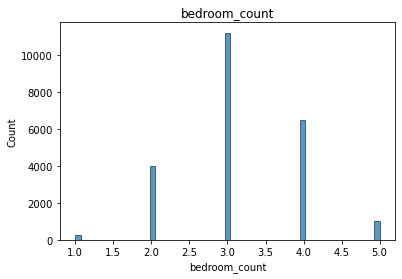

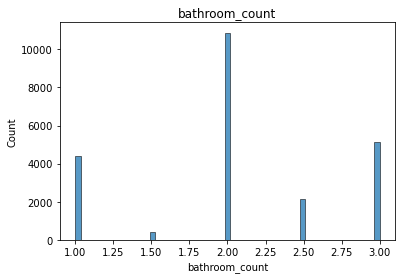

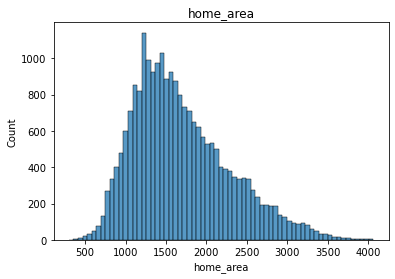

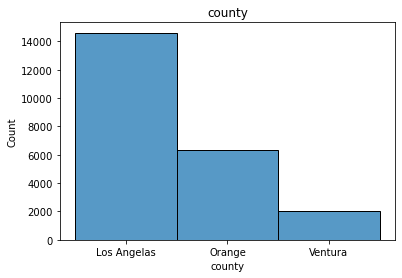

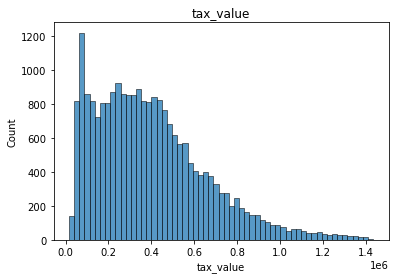

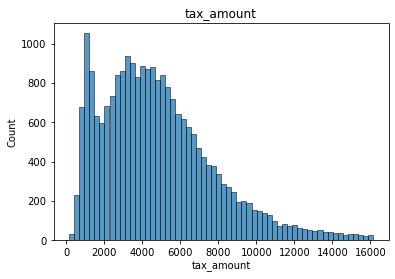

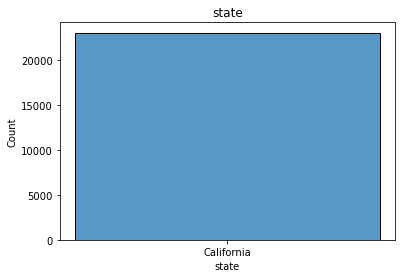

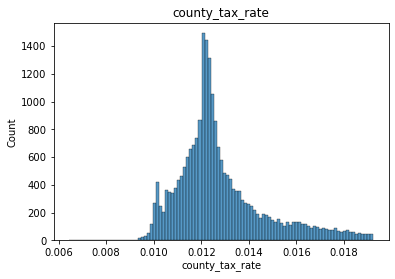

In [6]:
wrangle.get_dists(zillow)

***
__Plot the County Tax Rate Distributions__

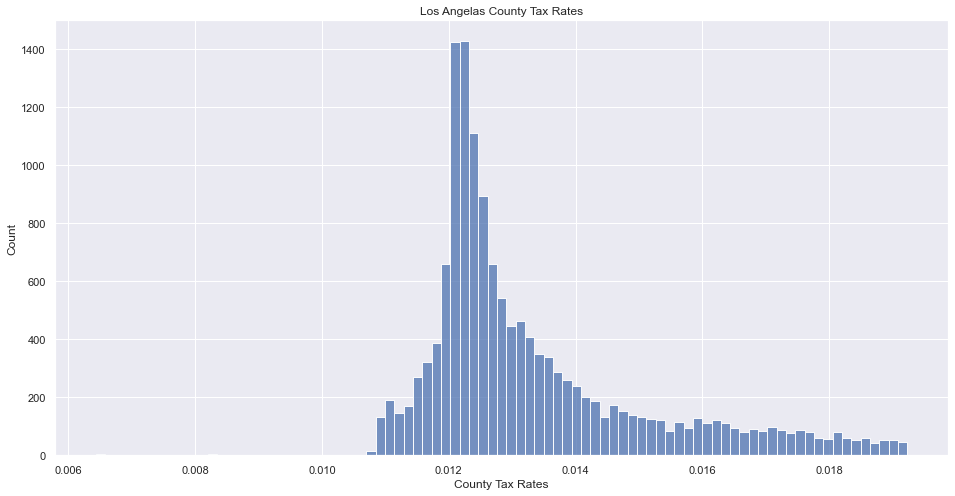

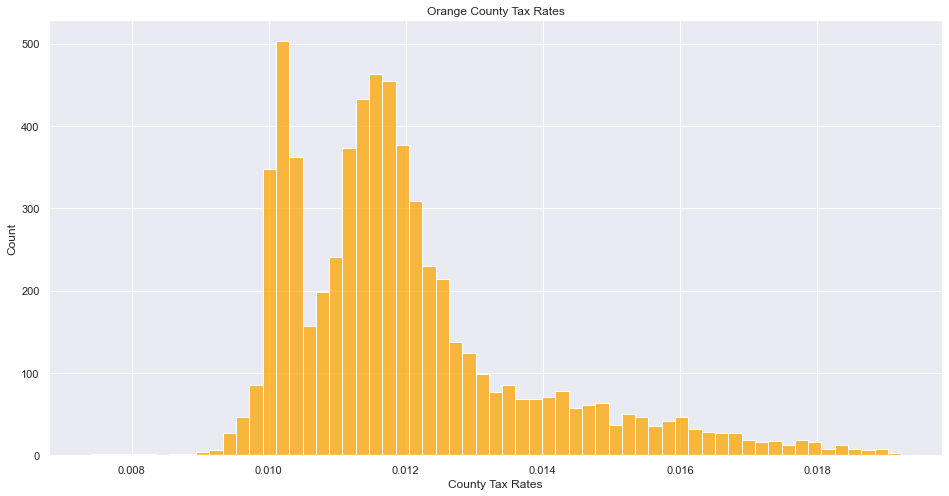

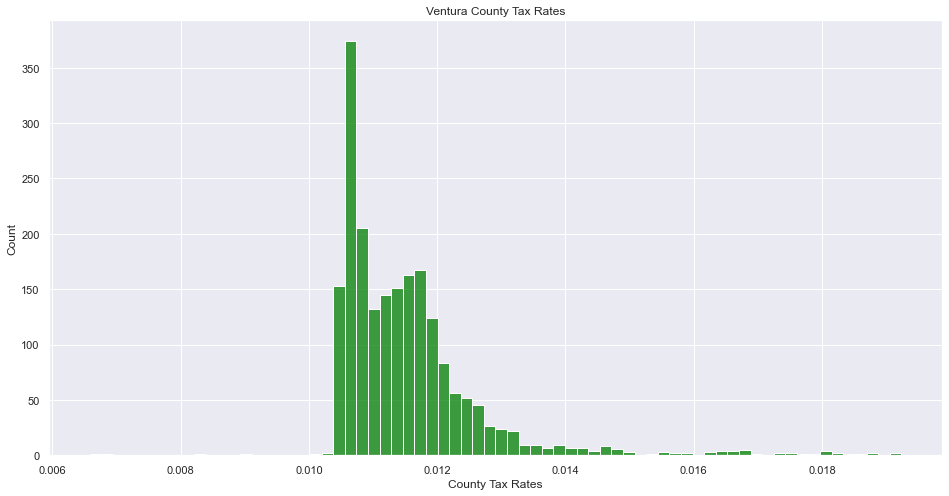

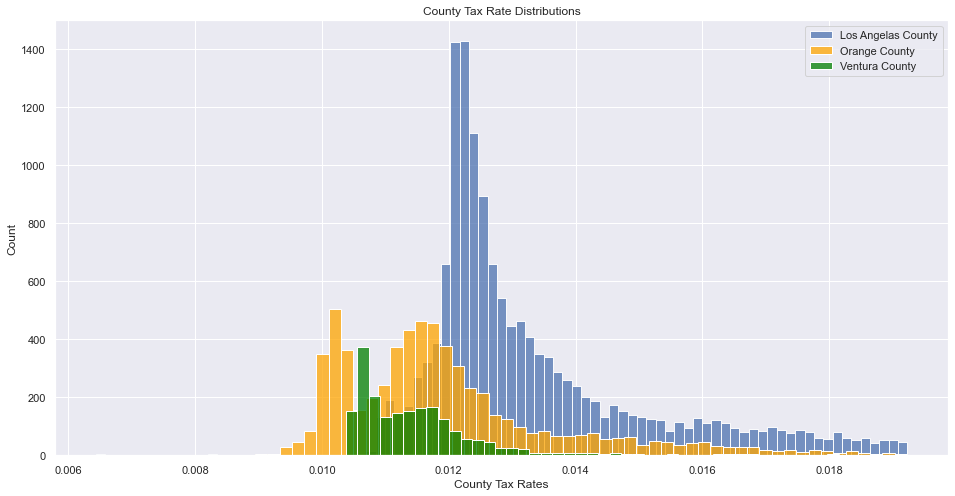

In [7]:
wrangle.get_tax_rate_dists(zillow)

***
__Split Data Into Train, Validate, and Test Datasets__

In [8]:
train, validate, test = wrangle.train_validate_test_split(zillow)
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (12882, 4)
validate -> (5521, 4)
test -> (4601, 4)


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12882 entries, 23141 to 22876
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedroom_count   12882 non-null  int64  
 1   bathroom_count  12882 non-null  float64
 2   home_area       12882 non-null  int64  
 3   tax_value       12882 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 503.2 KB


Key Takeaways:
* Removed 'county', 'state', 'county_tax_rate', and 'tax_amount' from the data sets.
* There are 23,004 total entries.
* All columns are numeric. There are no categorical variables.

***
### Explore Data

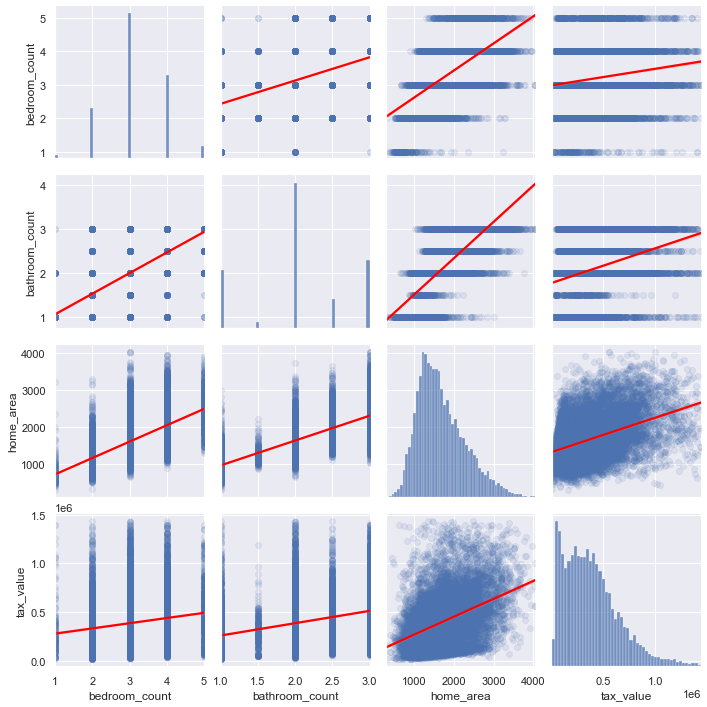

In [10]:
explore.get_pairwise_charts(train)

Key Takeaways:

* bedroom count and bathroom count have a weak positive relationship with tax_value.
* home_area has a much stronger positive linear relationship with tax_value.
* bedroom count and bathroom count have positive linear relationships with home_area, but that is expected.

***
### Statistical Testing

__Hypothesis 1__

$H_0$: bedroom_count is not linearly correlated with tax_value

$H_a$: bedroom_count is linearly correlated with tax_value

In [11]:
alpha = 0.05

In [12]:
corr, p = stats.pearsonr(train.bedroom_count, train.tax_value)
corr, p

(0.16293899010302537, 2.377759271934025e-77)

In [13]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


***
__Hypothesis 2__

$H_0$: bathroom_count is not linearly correlated with tax_value.
    
$H_a$: bathroom_count is linearly correlated with tax_value.

In [14]:
alpha = 0.05

In [15]:
corr, p = stats.pearsonr(train.bathroom_count, train.tax_value)
corr, p

(0.3172892951135475, 3.769935354504302e-299)

In [16]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


***
__Hypothesis 3__

$H_0$: home_area is not linearly correlated with tax_value.

$H_a$: home_area is linearly correlated with tax_value.

In [17]:
alpha = 0.05

In [18]:
corr, p = stats.pearsonr(train.home_area, train.tax_value)
corr, p

(0.41611993431866756, 0.0)

In [19]:
explore.is_significant(p, alpha)

p is less than alpha, so we reject the null hypothesis.


***
Key Takeaways:
* Both bedroom count and bathroom count are linearly correlated with tax_value, however bathroom count is more correlated than bedroom count.
* home_area is linearly correlated with tax_value and is the most correlated of the three variables.
* Since bedroom_count and bathroom_count are directly related to home_area, if I have time after the MVP is complete, I would like to do some feature engineering with other unrelated variables like location (lat, long) and county.

### Model and Evaluate
***

__Split Data Into X and y Groups__

In [20]:
X_train, y_train = train.drop('tax_value', axis = 1), train.tax_value
X_validate, y_validate = validate.drop('tax_value', axis = 1), validate.tax_value
X_test, y_test = test.drop('tax_value', axis = 1), test.tax_value

__Scale the X Data Groups__

In [21]:
X_train_scaled, X_validate_scaled, X_test_scaled = model.scale_data(X_train, X_validate, X_test)


__Compare Scaled Distributions to Original Distributions__

In [22]:
#Assign the scaled columns as new columns in each set
cols_to_scale = ['bedroom_count', 'bathroom_count', 'home_area']
cols_scaled = ['bedroom_count_scaled', 'bathroom_count_scaled', 'home_area_scaled']

train[cols_scaled] = X_train_scaled
validate[cols_scaled] = X_validate_scaled
test[cols_scaled] = X_test_scaled

/Users/johnathonsmith/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


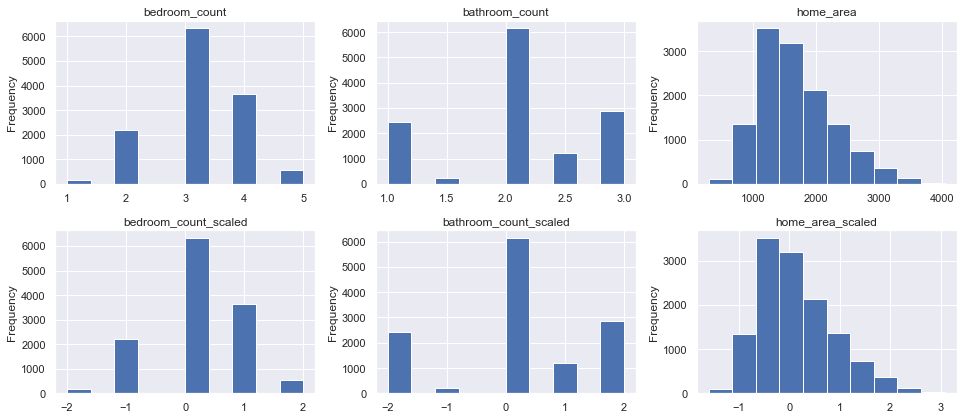

In [23]:
model.compare_dists(train, cols_to_scale, cols_scaled)


__Create Baseline Model__

I will create the baseline model using the 'tax_value' mean.

In [24]:
y_train, y_validate = model.get_baseline(y_train, y_validate)

RMSE using Mean
Train/In-Sample:  262170.33 
Validate/Out-of-Sample:  258013.69 




__Create OLS Model__

In [25]:
lm = model.get_ols_model(X_train_scaled, X_validate_scaled, y_train, y_validate)

RMSE using OLS
Train/In-Sample:  236525.67 
Validate/Out-of-Sample:  233033.15


__Create LassoLars Models__

In [26]:
lars_models = model.get_lars_models(X_train_scaled, X_validate_scaled, y_train, y_validate)


RMSE using LassoLars, alpha = 1
Train/In-Sample:  236525.82 
Validate/Out-of-Sample:  233023.21

RMSE using LassoLars, alpha = 11
Train/In-Sample:  236544.58 
Validate/Out-of-Sample:  232941.27

RMSE using LassoLars, alpha = 21
Train/In-Sample:  236594.6 
Validate/Out-of-Sample:  232891.13

RMSE using LassoLars, alpha = 31
Train/In-Sample:  236675.86 
Validate/Out-of-Sample:  232872.79

RMSE using LassoLars, alpha = 41
Train/In-Sample:  236788.33 
Validate/Out-of-Sample:  232886.27

RMSE using LassoLars, alpha = 51
Train/In-Sample:  236931.96 
Validate/Out-of-Sample:  232931.57

RMSE using LassoLars, alpha = 61
Train/In-Sample:  237106.69 
Validate/Out-of-Sample:  233008.66

RMSE using LassoLars, alpha = 71
Train/In-Sample:  237312.47 
Validate/Out-of-Sample:  233117.51

RMSE using LassoLars, alpha = 81
Train/In-Sample:  237549.2 
Validate/Out-of-Sample:  233258.08

RMSE using LassoLars, alpha = 91
Train/In-Sample:  237816.79 
Validate/Out-of-Sample:  233430.31


__Create GLM, TweedieRegressor Model__

In [27]:
glm = model.get_glm_model(X_train_scaled, X_validate_scaled, y_train, y_validate)

RMSE using TweedieRegressor
Train/In-Sample:  245043.69 
Validate/Out-of-Sample:  240444.68


__Create Polynomial Features and Model__

In [29]:
X_test_degree2, lm2 = model.get_polynomial_model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate)

RMSE using Polynomial Features
Train/In-Sample:  236336.67 
Validate/Out-of-Sample:  232927.54


__Choose Best Model__

After testing several models, I will choose the LassoLars model with an alpha = 31, since it performed the best so far.

I will wait to evaluate any model on the test set, until I am happy with my chosen model. As of now, I plan to go back and do some feature engineering and play around with the models a bit more.

### Conclusion
***

* All properties are located in California.
* All properties exist in either Los Angelas, Orange, or Ventura county.
* The individual county tax rates have been calculated and their distributions plotted at the end of the Wrangle section of this notebook.
* My best model was a LassoLars model with an alpha of 31. It outperformed all others, including the baseline, and had a validate RMSE of 232,872.79

### With More Time...
***

* I would like to do some feature engineering with location (lat, long) and county.
* I would also like to experiment with different alpha values for my LassoLars models and TweedieRegressor model.